In [1]:
import sys
# TODO: clean this up
sys.path.insert(0, "/Users/danieldubovski/projects/deep_query_optimization/")
sys.path

['/Users/danieldubovski/projects/deep_query_optimization/',
 '/Users/danieldubovski/projects/deep_query_optimization/dqo/datasets',
 '/Users/danieldubovski/projects/deep_query_optimization',
 '/usr/local/anaconda3/envs/py37/lib/python37.zip',
 '/usr/local/anaconda3/envs/py37/lib/python3.7',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/lib-dynload',
 '',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages',
 '/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/extensions',
 '/Users/danieldubovski/.ipython']

In [2]:
from dqo.datasets import QueriesDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
ds = QueriesDataset("tpcd2h:tpch")

In [4]:
db = ds.schema()

In [5]:
df = ds.load()

2021-01-26 09:45:41,277 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd2h/execution/tpch/runtimes/dqo-m.cayusbvr71xr.us-east-1.rds.amazonaws.com_tpcd2h_1611503282.csv [1/4]
2021-01-26 09:45:41,281 | dqo.datasets | INFO | Loaded 0 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd2h/execution/tpch/runtimes/dqo-m.cayusbvr71xr.us-east-1.rds.amazonaws.com_tpcd2h_1611503282.csv [1/4]
2021-01-26 09:45:41,282 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd2h/execution/tpch/runtimes/dqo-m.cayusbvr71xr.us-east-1.rds.amazonaws.com_tpcd2h_1611503303.csv [2/4]
2021-01-26 09:45:41,285 | dqo.datasets | INFO | Loaded 0 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd2h/execution/tpch/runtimes/dqo-m.cayusbvr71xr.us-east-1.rds.amazonaws.com_tpcd2h_1611503303.csv [2/4]
2021-01-26 09:45:41,286 | dqo.datasets

In [11]:
df.runtime.describe()

count    19696.000000
mean         3.201874
std         13.530354
min          0.000321
25%          0.287600
50%          0.654273
75%          1.348351
max        581.952404
Name: runtime, dtype: float64

In [10]:
df = df.query('runtime > 0')

(array([4567., 4423., 4775., 1790.,  622., 1699.,  359.,   43.,   13.,
          37.]),
 array([-3. , -1.8, -0.6,  0.6,  1.8,  3. ,  4.2,  5.4,  6.6,  7.8,  9. ]),
 <BarContainer object of 10 artists>)

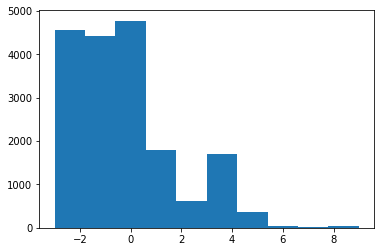

In [16]:
df['bucket'] = df.runtime.apply(np.log2).apply(np.round).apply(int)
plt.hist(df['bucket'])

In [14]:
df = df.query('bucket > -4')

In [15]:
df.groupby('bucket').count().min()

query      6
runtime    6
dtype: int64

In [10]:
df = ds.groom()

100%|██████████| 87119/87119 [13:39<00:00, 106.31it/s]


In [17]:
len(ds.df), len(df)

(19718, 18328)

In [18]:
ds.df = df

In [19]:
ds.save(prefix='clean')

In [23]:
ds2 = QueriesDataset('tpch:optimized')
df2 = ds2.load()

2021-01-26 09:51:18,772 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/optimized/runtimes/data_part_00.csv [1/1]
2021-01-26 09:51:19,157 | dqo.datasets | INFO | Loaded 22729 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpch/execution/optimized/runtimes/data_part_00.csv [1/1]


(array([4354., 8871., 3009., 1051.,  978., 2716.,  815.,  461.,  412.,
          62.]),
 array([-3. , -1.8, -0.6,  0.6,  1.8,  3. ,  4.2,  5.4,  6.6,  7.8,  9. ]),
 <BarContainer object of 10 artists>)

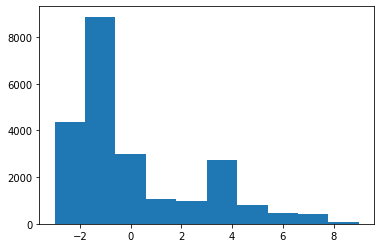

In [24]:
df2['bucket'] = df2.runtime.apply(np.log2).apply(np.round).apply(int)
plt.hist(df2['bucket'])

In [25]:
joined = pd.merge(df, df2, on='query')

In [26]:
len(joined)

18328

In [27]:
joined.head(1)

,query,runtime_x,bucket_x,runtime_y,bucket_y
0,"SELECT MIN(customer.c_address), MIN(customer.c...",0.709958,0,2.300877,1


In [31]:
joined['delta'] = np.abs(joined['bucket_x'] - joined['bucket_y'])

<AxesSubplot:>

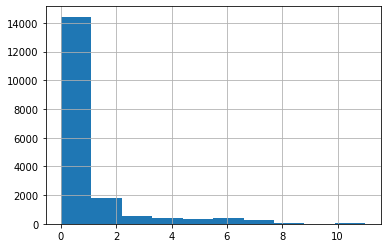

In [32]:
joined['delta'].hist()

In [38]:
far_apart = joined.query('delta > 8')

In [39]:
from dqo.relational import SQLParser

In [41]:
far_apart['tree'] = far_apart['query'].apply(SQLParser.to_relational_tree)

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
far_apart['realtions'] = far_apart['tree'].apply(lambda t:len(t.relations))
far_apart['nodes'] = far_apart['tree'].apply(lambda t:len(t))
far_apart['joins'] = far_apart['tree'].apply(lambda t:len(t.get_joins()))

/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

<AxesSubplot:>

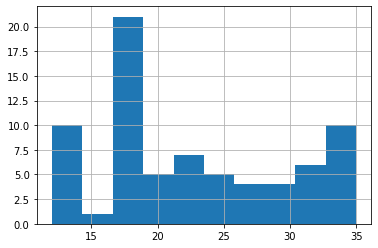

In [45]:
far_apart['nodes'].hist()

<AxesSubplot:>

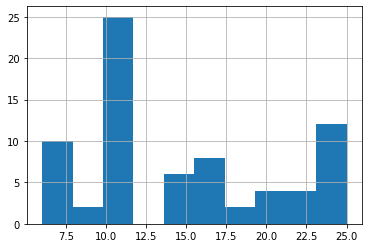

In [46]:
far_apart['joins'].hist()